# Sentimen Analisis Aplikasi Instagram di Google Play Store

# Import Library

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.6 MB/s eta 0:00:00


In [2]:
import csv
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import requests
from io import StringIO

import numpy as np
seed = 0
np.random.seed(seed) # Mengatur seed/titik awal untuk reproduktibilitas

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading Dataset

In [5]:
reviews_df = pd.read_csv('ulasan_instagram.csv')
reviews_df

,Review
0,"Mudah refresh terus, foto yg dilihat langsung ..."
1,Setelah update malah banyak bug. Di story tuli...
2,Banyak bug nya dan sampe sekarang belum diperb...
3,"Banyak bug, 1. notif pesan gada pdhl di setela..."
4,salah satu platform sosial media yang bisa dig...
...,...
9995,"ni ig kenapa dah, setiap mau bikin sg gambar s..."
9996,"punteun yeuh ige, ini ngapa tiap mau bikin sto..."
9997,Baru download udah minta update? Bukannya haru...
9998,"Gak bisa search lagu, lagu nya hilang semua ad..."


In [6]:
# Menampilkan informasi tentang DataFrame reviews_df
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10000 non-null  object
dtypes: object(1)
memory usage: 78.3+ KB


In [7]:
# Menampilkan duplikasi data
duplikasi = reviews_df.duplicated()
duplikasi[duplikasi > 0]

,0


In [8]:
reviews_df.isnull().sum()

,0
Review,0


# Preprocessing Data

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual","wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "pdhl" : "padahal", "gada" : "tidak ada"}

In [10]:
# Lakukan Case Folding
reviews_df['Review'] = reviews_df['Review'].str.lower()

In [11]:
# Text Cleaning
reviews_df['Review'] = reviews_df['Review'].str.replace(r'\d+', '', regex=True) # Case Folding
reviews_df['Review'] = reviews_df['Review'].str.replace(r'@[A-Za-z0-9_]+', '', regex=True)   # remove mentions
reviews_df['Review'] = reviews_df['Review'].str.replace(r'#[A-Za-z0-9_]+', '', regex=True)  # remove hashtags
reviews_df['Review'] = reviews_df['Review'].str.replace(r'RT[\s]+', '', regex=True)   # remove RT
reviews_df['Review'] = reviews_df['Review'].str.replace(r'http\S+', '', regex=True)   # remove links
reviews_df['Review'] = reviews_df['Review'].str.replace(r'[0-9]+', '', regex=True)    # remove numbers
reviews_df['Review'] = reviews_df['Review'].str.replace(r'[^\w\s]', '', regex=True)   # remove special characters
reviews_df['Review'] = reviews_df['Review'].str.replace('\n', ' ', regex=False)       # replace newline with space
reviews_df['Review'] = reviews_df['Review'].str.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
reviews_df['Review'] = reviews_df['Review'].str.strip()                               # remove leading/trailing spaces                             # case folding

In [12]:
# Memperbaiki slang words
fixed_reviews = []
for review in reviews_df['Review']:
    words = review.split()
    fixed_words = []
    for word in words:
        if word in slangwords:
            fixed_words.append(slangwords[word])
        else:
            fixed_words.append(word)
    fixed_review = ' '.join(fixed_words)
    fixed_reviews.append(fixed_review)

# Masukkan kembali ke kolom 'Review'
reviews_df['Fix Slang'] = fixed_reviews

In [13]:
# Tokenizing

reviews_df['Tokenized'] = reviews_df['Fix Slang'].apply(word_tokenize)

In [14]:
# Stopwords
list_stopwords = set(stopwords.words('indonesian'))
list_stopwords_eng = set(stopwords.words('english'))
list_stopwords.update(list_stopwords_eng)
list_stopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'])

# Stopword Removal
reviews_df['Stopword'] = reviews_df['Tokenized'].apply(lambda tokens: [word for word in tokens if word not in list_stopwords])

In [15]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

reviews_df['Stemmed_Text'] = reviews_df['Stopword'].apply(lambda tokens: stemmer.stem(' '.join(tokens)))

In [16]:
pd.set_option('display.max_colwidth', 3000)
reviews_df

,Review,Fix Slang,Tokenized,Stopword,Stemmed_Text
0,mudah refresh terus foto yg dilihat langsung hilang kebawah nyari jadi susah upload video juga susah padahal koneksi internet cepat dan stabil sering buffering dan bahkan saat nulis panjang instagram not response closed then hilang semua updaye pembaruan tidak dapat memuat ulang kabar beranda,mudah refresh terus foto yang dilihat langsung hilang kebawah mencari jadi susah upload video juga susah padahal koneksi internet cepat dan stabil sering buffering dan bahkan saat nulis panjang instagram not response closed then hilang semua updaye pembaruan tidak dapat memuat ulang kabar beranda,"[mudah, refresh, terus, foto, yang, dilihat, langsung, hilang, kebawah, mencari, jadi, susah, upload, video, juga, susah, padahal, koneksi, internet, cepat, dan, stabil, sering, buffering, dan, bahkan, saat, nulis, panjang, instagram, not, response, closed, then, hilang, semua, updaye, pembaruan, tidak, dapat, memuat, ulang, kabar, beranda]","[mudah, refresh, foto, langsung, hilang, kebawah, mencari, susah, upload, video, susah, koneksi, internet, cepat, stabil, buffering, nulis, instagram, response, closed, hilang, updaye, pembaruan, memuat, ulang, kabar, beranda]",mudah refresh foto langsung hilang bawah cari susah upload video susah koneksi internet cepat stabil buffering nulis instagram response closed hilang updaye baru muat ulang kabar beranda
1,setelah update malah banyak bug di story tulisan nya musik tidak di temukan semua story orang yang pakai musik di saya itu tulisan nya musik tidak tersedia udah segala cara di cobaga ada yang bisaa semua alasan sama katanya wilayah wilayah serumah aja dia aman ig nya kenapa saya bermasalah uninstall berkali kali logout login update semuanya udah makin kesini kenapa sih respon dong tolong,setelah update bahkan banyak bug di story tulisan nya musik tidak di temukan semua story orang yang pakai musik di saya itu tulisan nya musik tidak tersedia sudah segala cara di cobaga ada yang bisaa semua alasan sama katanya wilayah wilayah serumah saja dia aman ig nya kenapa saya bermasalah uninstall berkali kali logout login update semuanya sudah makin kesini kenapa sih respon dong tolong,"[setelah, update, bahkan, banyak, bug, di, story, tulisan, nya, musik, tidak, di, temukan, semua, story, orang, yang, pakai, musik, di, saya, itu, tulisan, nya, musik, tidak, tersedia, sudah, segala, cara, di, cobaga, ada, yang, bisaa, semua, alasan, sama, katanya, wilayah, wilayah, serumah, saja, dia, aman, ig, nya, kenapa, saya, bermasalah, uninstall, berkali, kali, logout, login, update, semuanya, sudah, makin, kesini, kenapa, sih, respon, dong, tolong]","[update, bug, story, tulisan, musik, temukan, story, orang, pakai, musik, tulisan, musik, tersedia, cobaga, bisaa, alasan, wilayah, wilayah, serumah, aman, ig, bermasalah, uninstall, berkali, kali, logout, login, update, kesini, respon, tolong]",update bug story tulis musik temu story orang pakai musik tulis musik sedia cobaga bisaa alas wilayah wilayah rumah aman ig masalah uninstall kali kali logout login update kesini respon tolong
2,banyak bug nya dan sampe sekarang belum diperbaiki padahal udh report ke bagian cs nya dan masi belum ada perubahan bug yang aku temui berupa beberapa fitur update terbaru tidak ada tombolnya gaada tombol reply di dm dll terkadang instagram saya putih dan tidak keliatan tulisan apapun kecuali gambar postingannya sendiri dll masi banyak banget yg diatas itu yg paling ngeselin si ps system algorithm nya kaya kontool akun bisnis kecil susah berkembang sekian sahabat,banyak bug nya dan sampai sekarang belum diperbaiki padahal udh report ke bagian cs nya dan masih belum ada perubahan bug yang aku temui berupa beberapa fitur update terbaru tidak ada tombolnya tidak ada uang tombol reply di dm dan lain-lain terkadang instagram saya putih dan tidak kelihatan tulisan apapun kecuali gambar postingannya sendiri dan lain-lain masih banyak banget yang diatas itu yang paling ngeselin si ps system algori

# Pelabelan

In [17]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [18]:
# Melakukan pelabelan pada dataset

def get_sentiment_score(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    return score

In [19]:
# Melakukan tokenisasi ulang dari kata yang sudah di stemming
reviews_df['tokens2'] = reviews_df['Stemmed_Text'].astype(str).apply(word_tokenize)

In [20]:
# Hitung skor sentimen dari setiap teks
reviews_df['polarity_score'] = reviews_df['tokens2'].apply(get_sentiment_score)

# Tentukan polaritas berdasarkan skor
reviews_df['polarity'] = reviews_df['polarity_score'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)

In [21]:
reviews_df['polarity'].value_counts()

,count
polarity,
positive,7391
negative,2169
neutral,440


In [22]:
reviews_df

,Review,Fix Slang,Tokenized,Stopword,Stemmed_Text,tokens2,polarity_score,polarity
0,mudah refresh terus foto yg dilihat langsung hilang kebawah nyari jadi susah upload video juga susah padahal koneksi internet cepat dan stabil sering buffering dan bahkan saat nulis panjang instagram not response closed then hilang semua updaye pembaruan tidak dapat memuat ulang kabar beranda,mudah refresh terus foto yang dilihat langsung hilang kebawah mencari jadi susah upload video juga susah padahal koneksi internet cepat dan stabil sering buffering dan bahkan saat nulis panjang instagram not response closed then hilang semua updaye pembaruan tidak dapat memuat ulang kabar beranda,"[mudah, refresh, terus, foto, yang, dilihat, langsung, hilang, kebawah, mencari, jadi, susah, upload, video, juga, susah, padahal, koneksi, internet, cepat, dan, stabil, sering, buffering, dan, bahkan, saat, nulis, panjang, instagram, not, response, closed, then, hilang, semua, updaye, pembaruan, tidak, dapat, memuat, ulang, kabar, beranda]","[mudah, refresh, foto, langsung, hilang, kebawah, mencari, susah, upload, video, susah, koneksi, internet, cepat, stabil, buffering, nulis, instagram, response, closed, hilang, updaye, pembaruan, memuat, ulang, kabar, beranda]",mudah refresh foto langsung hilang bawah cari susah upload video susah koneksi internet cepat stabil buffering nulis instagram response closed hilang updaye baru muat ulang kabar beranda,"[mudah, refresh, foto, langsung, hilang, bawah, cari, susah, upload, video, susah, koneksi, internet, cepat, stabil, buffering, nulis, instagram, response, closed, hilang, updaye, baru, muat, ulang, kabar, beranda]",17,positive
1,setelah update malah banyak bug di story tulisan nya musik tidak di temukan semua story orang yang pakai musik di saya itu tulisan nya musik tidak tersedia udah segala cara di cobaga ada yang bisaa semua alasan sama katanya wilayah wilayah serumah aja dia aman ig nya kenapa saya bermasalah uninstall berkali kali logout login update semuanya udah makin kesini kenapa sih respon dong tolong,setelah update bahkan banyak bug di story tulisan nya musik tidak di temukan semua story orang yang pakai musik di saya itu tulisan nya musik tidak tersedia sudah segala cara di cobaga ada yang bisaa semua alasan sama katanya wilayah wilayah serumah saja dia aman ig nya kenapa saya bermasalah uninstall berkali kali logout login update semuanya sudah makin kesini kenapa sih respon dong tolong,"[setelah, update, bahkan, banyak, bug, di, story, tulisan, nya, musik, tidak, di, temukan, semua, story, orang, yang, pakai, musik, di, saya, itu, tulisan, nya, musik, tidak, tersedia, sudah, segala, cara, di, cobaga, ada, yang, bisaa, semua, alasan, sama, katanya, wilayah, wilayah, serumah, saja, dia, aman, ig, nya, kenapa, saya, bermasalah, uninstall, berkali, kali, logout, login, update, semuanya, sudah, makin, kesini, kenapa, sih, respon, dong, tolong]","[update, bug, story, tulisan, musik, temukan, story, orang, pakai, musik, tulisan, musik, tersedia, cobaga, bisaa, alasan, wilayah, wilayah, serumah, aman, ig, bermasalah, uninstall, berkali, kali, logout, login, update, kesini, respon, tolong]",update bug story tulis musik temu story orang pakai musik tulis musik sedia cobaga bisaa alas wilayah wilayah rumah aman ig masalah uninstall kali kali logout login update kesini respon tolong,"[update, bug, story, tulis, musik, temu, story, orang, pakai, musik, tulis, musik, sedia, cobaga, bisaa, alas, wilayah, wilayah, rumah, aman, ig, masalah, uninstall, kali, kali, logout, login, update, kesini, respon, tolong]",14,positive
2,banyak bug nya dan sampe sekarang belum diperbaiki padahal udh report ke bagian cs nya dan masi belum ada perubahan bug yang aku temui berupa beberapa fitur update terbaru tidak ada tombolnya gaada tombol reply di dm dll terkadang instagram saya putih dan tidak keliatan tulisan apapun kecuali gambar postingannya sendiri dll masi banyak banget yg diatas itu yg paling ngeselin si ps system algorithm n

### Visualisasi

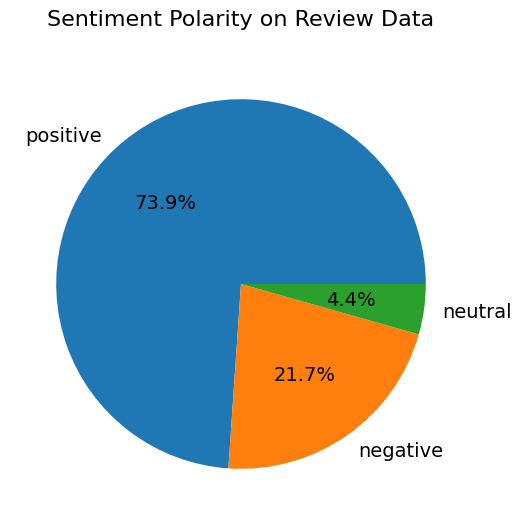

In [23]:
import matplotlib.pyplot as plt

# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in reviews_df['polarity'].value_counts()]
labels = list(reviews_df['polarity'].value_counts().index)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

In [24]:
# Menyaring ulasan dengan polaritas positif
positive_review = reviews_df[reviews_df['polarity'] == 'positive']
positive_review = positive_review[['Stemmed_Text', 'polarity_score', 'polarity','Stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [25]:
# Menyaring ulasan dengan polaritas negative
negative_review = reviews_df[reviews_df['polarity'] == 'negative']
negative_review = negative_review[['Stemmed_Text', 'polarity_score', 'polarity','Stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [26]:
# # Menyaring ulasan dengan polaritas neutral
neutral_review = reviews_df[reviews_df['polarity'] == 'neutral']
neutral_review = neutral_review[['Stemmed_Text', 'polarity_score', 'polarity','Stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

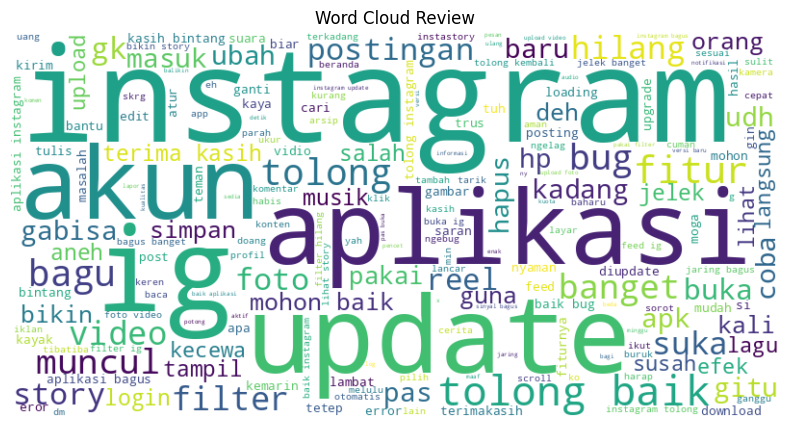

In [27]:
# Menampilkan kata kata yang sering muncul
word = ' '.join(reviews_df['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Review')
plt.show()

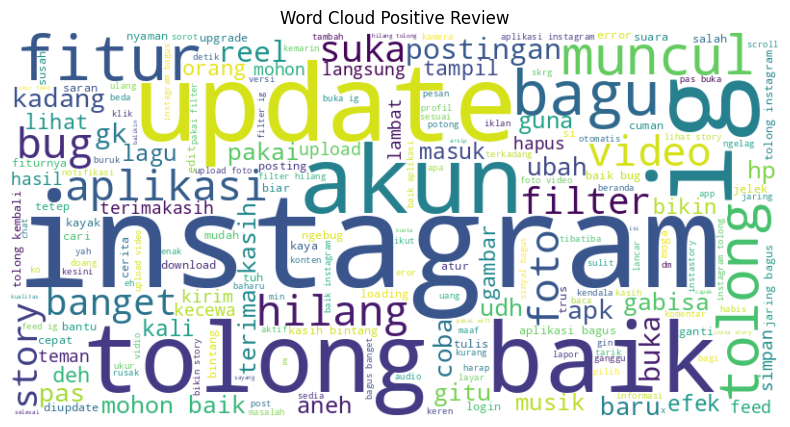

In [28]:
# Menampilkan kata kata positive yang sering muncul
word = ' '.join(positive_review['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Positive Review')
plt.show()

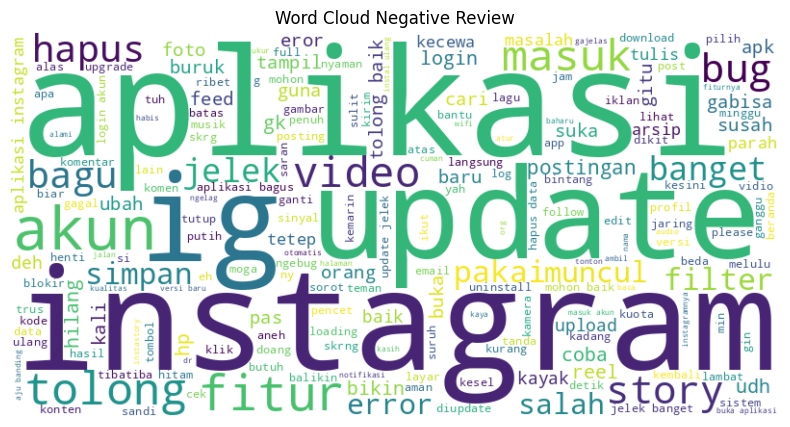

In [29]:
# Menampilkan kata kata negative yang sering muncul
word = ' '.join(negative_review['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Negative Review')
plt.show()

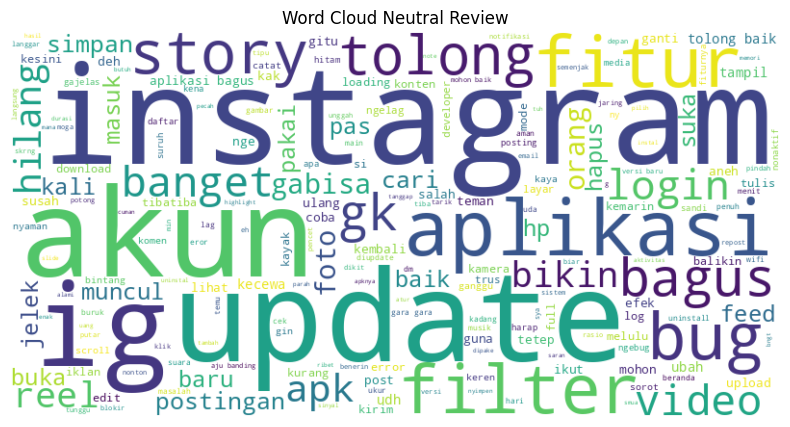

In [30]:
# Menampilkan kata kata netural yang sering muncul
word = ' '.join(neutral_review['Stemmed_Text'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(word)

# Tampilkan dengan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Neutral Review')
plt.show()

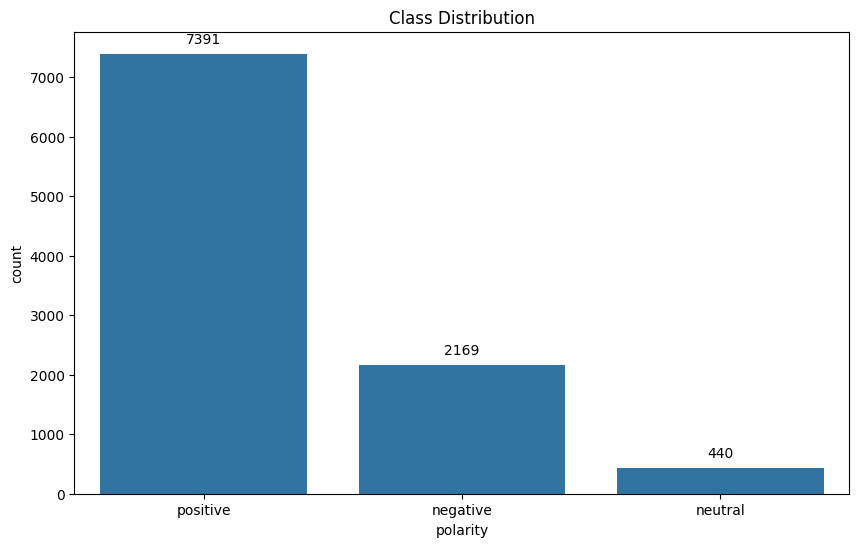

In [31]:
# Menampilkan distribusi kelas
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=reviews_df)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

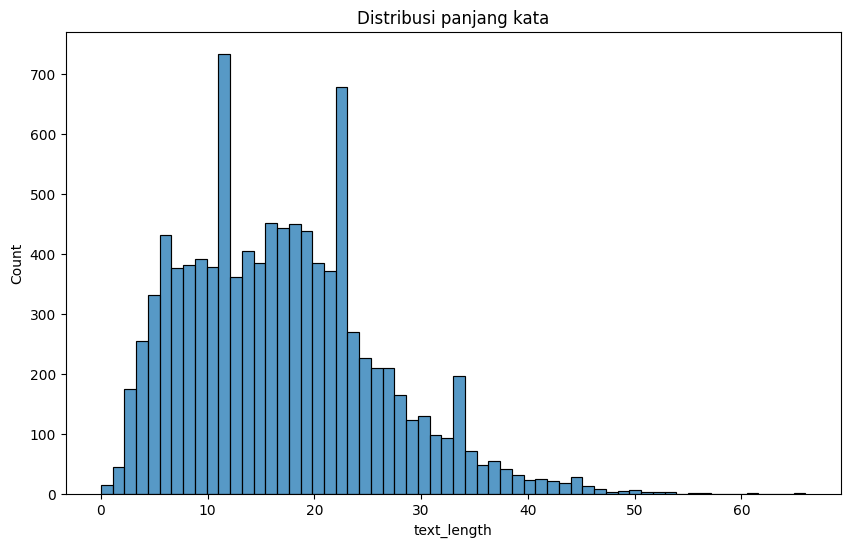

In [32]:
plt.figure(figsize=(10, 6))

# Visualize text length distribution
reviews_df['text_length'] = reviews_df['Stemmed_Text'].astype(str).apply(lambda x: len(x.split()))
sns.histplot(reviews_df['text_length'])
plt.title('Distribusi panjang kata')
plt.show()

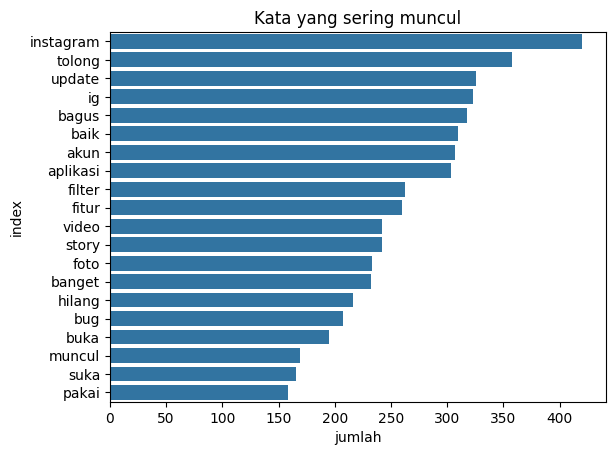

In [33]:
# Visualize kata yang sering muncul
vectorizer = TfidfVectorizer()
# Mengatasi missing values dengan menggantinya dengan string kosong
reviews_df['Stemmed_Text'] = reviews_df['Stemmed_Text'].fillna('')
X = vectorizer.fit_transform(reviews_df['Stemmed_Text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata yang sering muncul')
plt.show()

# Data Splitting

In [34]:
# Memisahkan data menjadi fitur dan label
x = reviews_df['Stemmed_Text']
y = reviews_df['polarity']

### Ekstreksi Fitur dengan Count Vectorizer

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorizer = vectorizer.fit_transform(reviews_df['Stemmed_Text'])

In [70]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_vectorizer.toarray(), columns=vectorizer.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,abadi,abai,abu,acak,acara,accord,account,ada,adaa,adaaa,...,yahh,yak,yapadahal,ye,yh,yng,youtube,yt,zaman,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_vectorizer, y, test_size=0.2, random_state=42)

### Modeling dengan algoritma LogisticRegression

In [75]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.989875
Logistic Regression - accuracy_test: 0.8885


### Modeling dengan algoritma random forest

In [76]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.999875
Random Forest - accuracy_test: 0.8155


### Modeling dengan algoritma LSTM

In [40]:
# Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews_df['Stemmed_Text'].astype(str))
sequences = tokenizer.texts_to_sequences(reviews_df['Stemmed_Text'].astype(str))

# Padding
max_len = 100
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(reviews_df['polarity'])

# One-hot encoding
labels_categorical = to_categorical(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded, labels_categorical, test_size=0.3, random_state=42)

In [41]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # output = jumlah kelas
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.7311 - loss: 0.7385
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7353 - loss: 0.7157
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.7320 - loss: 0.7134
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.7410 - loss: 0.7028
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.7465 - loss: 0.6954
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.7347 - loss: 0.7058
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.7335 - loss: 0.7102
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.7319 - loss: 0.7171
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7424 - loss: 0.6946
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.7346 - loss: 0.7022


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7425 - loss: 0.6815

Test Accuracy: 0.7467


# Menyimpan model random forest

In [ ]:
import joblib

# Simpan model ke file
joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

# Membuat File Requirements

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!cat requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
communi

In [ ]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>